In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torchvision
from torchvision import datasets, transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
import timm
import cv2
import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from pathlib import Path
from sklearn.model_selection import train_test_split
from albumentations.core.transforms_interface import DualTransform

from efficientnet_pytorch import EfficientNet

from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
from PIL import Image, ImageOps, ImageEnhance

In [2]:
torchvision.__version__, torch.__version__ # ('0.11.2+cu111', '1.10.0+cu111')

('0.11.2+cu111', '1.10.1+cu111')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [5]:
class CFG:

  epochs =20                              # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  BATCH_SIZE = 50
  N_EPOCHS = 30                        # Batch Size for Dataset

#   model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  IMG=224
  img_size = (IMG,IMG)                        # Resize all the images to be 224 by 224
  
  # going to be used for loading dataset
  ds_path = "/path/to/image"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device on which we are:{}".format(device))

device on which we are:cuda


In [6]:
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [7]:
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)

In [8]:


import albumentations
import albumentations.pytorch

In [9]:
test_transformer=albumentations.Compose([
    albumentations.Resize(224,224),
    albumentations.pytorch.ToTensorV2()
])

In [10]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform:
            res = self.transform(image=img)
            img = res['image']
        else:
            img = img

        return (img, label)

In [12]:
test=Dataset(test_dir,test_transformer)

In [13]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [14]:
test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=16)


In [16]:
torch.backends.cudnn.benchmark = True
### Obtained from Paper ###
# Configs taken from 
# https://github.com/leondgarse/keras_efficientnet_v2/blob/main/keras_efficientnet_v2/efficientnet_v2.py
# convs parameter is which type of block to use, maps to `layer_map`
# 6 models are supported, more are coming soon.
CONFIGS = {
    "b0": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [1, 2, 2, 3, 5, 8],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights": "tf_efficientnetv2_b0",
    },
    "b1": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [2, 3, 3, 4, 6, 9],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs":[0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_b1",
    },
    "b2": {
        "widths": [32, 16, 32, 56, 104, 120, 208],
        "depths": [2, 3, 3, 4, 6, 10],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1408,
        "timm_weights":"tf_efficientnetv2_b2",
    },
    "s": {
        "widths": [24, 24, 48, 64, 128, 160, 256],
        "depths": [2, 4, 4, 6, 9, 15],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights": "tf_efficientnetv2_s"
    },
    "m": {
        "widths": [24, 24, 48, 80, 160, 176, 304, 512],
        "depths": [3, 5, 5, 7, 14, 18, 5],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_m",
    },
    "l": {
        "widths": [32, 32, 64, 96, 192, 224, 384, 640],
        "depths": [4, 7, 7, 10, 19, 25, 7],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_l",
    }
}

In [17]:
def conv_block(in_channels, out_channels, kernel_size=3, 
               stride=1, padding=1, groups=1,
               bias=False, bn=True, act = True):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, 
                  padding=padding, groups=groups, bias=bias),
        nn.BatchNorm2d(out_channels) if bn else nn.Identity(),
        nn.SiLU() if act else nn.Identity()
    ]
    return nn.Sequential(*layers)

In [18]:
class SEBlock(nn.Module):
    def __init__(self, c, r=24):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveMaxPool2d(1)
        self.excitation = nn.Sequential(
            nn.Conv2d(c, c // r, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(c // r, c, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        s = self.squeeze(x)
        e = self.excitation(s)
        return x * e

In [19]:
class MBConv(nn.Module):
    def __init__(self, n_in, n_out, expansion, kernel_size=3, stride=1, r=24, dropout=0.1):
        super(MBConv, self).__init__()
        self.skip_connection = (n_in == n_out) and (stride == 1)
        
        padding = (kernel_size-1)//2
        expanded = expansion*n_in
        
        self.expand_pw = nn.Identity() if expansion == 1 else conv_block(n_in, expanded, kernel_size=1, padding=0)
        self.depthwise = conv_block(expanded, expanded, kernel_size=kernel_size, 
                                    stride=stride, padding=padding, groups=expanded)
        self.se = SEBlock(expanded, r=4 * expansion)
        self.reduce_pw = conv_block(expanded, n_out, kernel_size=1, padding=0, act=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.expand_pw(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.reduce_pw(x)
        if self.skip_connection:
            x = self.dropout(x)
            x = x + residual
        return x

In [20]:
class FusedMBConv(nn.Module):
    def __init__(self, n_in, n_out, expansion, kernel_size=3, stride=1, r=24, dropout=0.1):
        super(FusedMBConv, self).__init__()
        self.skip_connection = (n_in == n_out) and (stride == 1)
        padding = (kernel_size-1)//2
        expanded = expansion*n_in
        
        self.expand_pw = conv_block(n_in, expanded, kernel_size=3, stride=stride, padding=1)
        self.reduce_pw = conv_block(expanded, n_out, kernel_size=1, padding=0, act=False)
        
        if expansion == 1:
            self.reduce_pw = nn.Identity() # for consistency with timm implementation
            self.expand_pw = conv_block(n_in, n_out, kernel_size=3, stride=stride, padding=1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.expand_pw(x)
        x = self.reduce_pw(x)
        if self.skip_connection:
            x = self.dropout(x)
            x = x + residual
        return x

In [21]:
def mbconv4(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return MBConv(n_in, n_out, 4, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def mbconv6(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return MBConv(n_in, n_out, 6, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def fused_mbconv1(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return FusedMBConv(n_in, n_out, 1, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def fused_mbconv4(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return FusedMBConv(n_in, n_out, 4, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
layers_map = [fused_mbconv1, fused_mbconv4, mbconv4, mbconv6]

In [22]:
def create_stage(n_in, n_out, num_layers, layer=mbconv6, 
                 kernel_size=3, stride=1, r=24, ps=0):
    layers = [layer(n_in, n_out, kernel_size=kernel_size,
                       stride=stride, r=r, dropout=ps)]
    layers += [layer(n_out, n_out, kernel_size=kernel_size,
                        r=r, dropout=ps) for _ in range(num_layers-1)]
    return nn.Sequential(*layers)

In [23]:
class EfficientNetV2(nn.Module):
    """
    Generic EfficientNet V2 Class.
    """
    def __init__(self, cfg, n_classes=3):
        super(EfficientNetV2, self).__init__()
        self.cfg = cfg
        self.n_classes = n_classes
        widths, depths, strides, convs = cfg['widths'],cfg['depths'],cfg['strides'],cfg['convs']
        outconv_size = cfg['output_conv_size']
        
        stages = [conv_block(3, widths[0], stride=2, padding=1)]
        for i in range(len(depths)):
            stages.append(create_stage(widths[i], widths[i + 1], depths[i], layer=layers_map[convs[i]], 
                        stride=strides[i], r=4 if i ==0 else 24, ps=0))

        self.features = nn.Sequential(*stages)
        self.pre = conv_block(widths[-1], outconv_size, kernel_size=1, padding=0)
        self.pool_flatten = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten())
        self.head = nn.Sequential(
            nn.Linear(outconv_size, n_classes)
        )
            
    def forward(self, x):
        x = self.features(x)
        x = self.pre(x)
        x = self.pool_flatten(x)
        x = self.head(x)
        return x

In [24]:
def efficientnetv2_b0(n_classes=3):
    return EfficientNetV2(CONFIGS['b0'], n_classes=n_classes)
def efficientnetv2_b1(n_classes=3):
    return EfficientNetV2(CONFIGS['b1'], n_classes=n_classes)
def efficientnetv2_b2(n_classes=3):
    return EfficientNetV2(CONFIGS['b2'], n_classes=n_classes)
def efficientnetv2_s(n_classes=3):
    return EfficientNetV2(CONFIGS['s'], n_classes=n_classes)
def efficientnetv2_m(n_classes=3):
    return EfficientNetV2(CONFIGS['m'], n_classes=n_classes)
def efficientnetv2_l(n_classes=3):
    return EfficientNetV2(CONFIGS['l'], n_classes=n_classes)

In [25]:
classes=['A','B','C']

In [26]:
def load_timm_weights(model):
    url = model.cfg.get("timm_weights")
    timm_model = timm.create_model(url, pretrained=True, num_classes=len(classes))
    params = nn.utils.parameters_to_vector(timm_model.parameters())
    nn.utils.vector_to_parameters(params, model.parameters())

In [27]:
model = efficientnetv2_s(n_classes=len(classes))
load_timm_weights(model)
for param in model.parameters():
    param.requires_grad = False
    
n_inputs = model.head[0].in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs,512),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)

In [28]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [29]:
def test_eval(model):
  test_loss = 0.0
  correct_num=0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()
  test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=25)

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda().float(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      correct_num+=torch.sum(correct_tensor)
      for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
  test_acc=correct_num/len(test_loader.dataset)
  print('Test acc: {:.6f}\n'.format(test_acc))
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [30]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [32]:
from tqdm import tqdm
import time
import copy
test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=16)

In [33]:
for i in range(5):
    model.load_state_dict(torch.load(f'./weights/model_5e_{i}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    test_eval(model)

100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Test acc: 0.670000

Test Loss: 0.716669

Test Accuracy of     A: 72% (72/100)
Test Accuracy of     B: 47% (47/100)
Test Accuracy of     C: 82% (82/100)

Test Accuracy (Overall): 67.0000 (201.0/300.0)


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


Test acc: 0.686667

Test Loss: 0.663039

Test Accuracy of     A: 69% (69/100)
Test Accuracy of     B: 62% (62/100)
Test Accuracy of     C: 75% (75/100)

Test Accuracy (Overall): 68.6667 (206.0/300.0)


100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Test acc: 0.693333

Test Loss: 0.668602

Test Accuracy of     A: 80% (80/100)
Test Accuracy of     B: 35% (35/100)
Test Accuracy of     C: 93% (93/100)

Test Accuracy (Overall): 69.3333 (208.0/300.0)


100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


Test acc: 0.656667

Test Loss: 0.715718

Test Accuracy of     A: 58% (58/100)
Test Accuracy of     B: 57% (57/100)
Test Accuracy of     C: 82% (82/100)

Test Accuracy (Overall): 65.6667 (197.0/300.0)


100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

Test acc: 0.670000

Test Loss: 0.690148

Test Accuracy of     A: 86% (86/100)
Test Accuracy of     B: 32% (32/100)
Test Accuracy of     C: 83% (83/100)

Test Accuracy (Overall): 67.0000 (201.0/300.0)


In [34]:
models=[]
for i in range(5):
    model.load_state_dict(torch.load(f'./weights/model_5e_{i}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    models.append(model)

In [35]:
def get_all_preds_k_fold(models,loader):
  all_preds=torch.tensor([])
  ground_truth=torch.tensor([])
  running_loss=0
  model1=models[0]
  model2=models[1]
  model3=models[2]
  model4=models[3]
  model5=models[4]
  for batch in loader:
    images,labels=batch
    images=images.to(device).float()
    labels=labels.to('cpu')

    ground_truth=torch.cat((ground_truth,labels),dim=0)
    p1=model1(images).to('cpu')
    p2=model2(images).to('cpu')
    p3=model3(images).to('cpu')
    p4=model4(images).to('cpu')
    p5=model5(images).to('cpu')
    preds=(p1+p2+p3+p4+p5)/5

    all_preds=torch.cat((all_preds,preds),dim=0)
    loss_val = criterion(preds, labels)
    running_loss += loss_val.item() * images.size(0)
  
  loss=running_loss/len(loader)
  return all_preds,ground_truth,loss

In [36]:
torch.cuda.empty_cache()

In [37]:
with torch.no_grad():
      prediction_loader=torch.utils.data.DataLoader(test,batch_size=int(len(test)/300),num_workers=8)
      test_preds,ground_truth,loss=get_all_preds_k_fold(models,prediction_loader)

In [38]:
def get_num_correct(preds,labels):
  print(preds.argmax(dim=1).eq(labels).sum().item()/len(preds))

In [39]:
get_num_correct(test_preds,ground_truth)

0.6733333333333333


In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ground_truth,test_preds.argmax(dim=1))
print(type(cm))

<class 'numpy.ndarray'>


In [41]:

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),fontsize=30, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


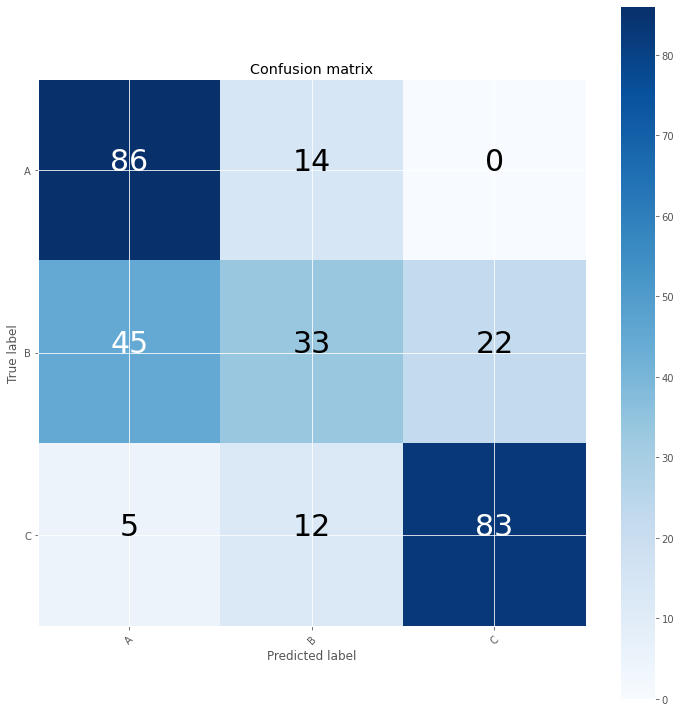

In [42]:
names=('A','B','C')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)